In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [1]:
import numpy as np
from numpy import inf
from scipy.stats import linregress
from scipy.stats import pearsonr
import itertools
from matplotlib import pyplot as plt
from matplotlib.lines import Line2D
from matplotlib.patches import Patch
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Liberation Serif']
plt.rcParams['font.sans-serif'] = ['Liberation Sans']
from matplotlib.colors import LinearSegmentedColormap
import seaborn as sns
import os

In [2]:
FIG_WIDTH = 20
FIG_HEIGHT = 6
LABEL_SIZE = 30
SCATTER_PLOT_X_LABEL = 'number of data points'
COLORS = {
    'NCC-LR': '#117733',
    'NCC-HR': '#117733',
    'MPI-LR': '#882255',
    'MPI-HR': '#882255',
    'MOHC-LR': '#332288',
    'MOHC-HR': '#332288',
    'IPSL': '#88CCEE',
    'JAP': '#CC6677',
    'CMCC': '#999933',
    'EC-EARTH': '#44AA99',
    'ERA5': 'black',
}

In [3]:
class FileInformation:
    def __init__(self, file_name):
        self.file_name = file_name
        loaded_data = np.load(file_name)
        self.res = loaded_data['x']
        self.mean = loaded_data['mean']
        self.max = loaded_data['max']
        self.js = loaded_data['js']
        self.w1 = loaded_data['w1']
        components = file_name.split('/')[-1].split('.')[0].split('_')
        model_category = components.pop(1)
        self.model_category = model_category
        model_name = components.pop(1)
        self.model_name = model_name
        self.color = COLORS[model_name]
        marker = 'o'
        size = 250
        if 'LR' in model_name:
            marker = 'X'
            size = 350
        self.model_label = model_name
        self.arguments = {'color': self.color, 'marker': marker, 's':size}

In [4]:
def create_model_file_list(height):
  list_of_models = []
  root = f'/content/drive/MyDrive/Paper Spatial Resolution/trends/'
  for root, dirs, files in os.walk(root):
      for filename in files:
        if str(height) in filename:
            file_path = os.path.join(root, filename)
            my_file = FileInformation(file_path)
            list_of_models.append(my_file)
  return list_of_models

In [5]:
def linear(x, a, b):
    return a * x + b

def plot_regression_line_with_log_x(x, v, ax, name):
    log_x = np.log10(x)
    slope, intercept, r, p, se = linregress(log_x, np.array(v))
    print(f"{name}: Intercept Slope St.Dev. R-squared  P-value")
    print(f"{name} & {intercept:.3f} & {slope:.3f} & {se:.3f} & {r ** 2 * 100:.3f} & {p:.4f} \\\\")
    x_fit = np.logspace(log_x.min()-0.1, log_x.max()+0.1, 100)
    log_x_fit = np.log10(x_fit)
    y_fit = linear(log_x_fit, slope, intercept)
    ax.plot(x_fit, y_fit, color='grey', linewidth=1,
            label='Regression Line', zorder=0)
    std_errors = np.full_like(x_fit, se)
    ax.fill_between(x_fit, y_fit - std_errors, y_fit + std_errors,
                  color='grey', alpha=0.3, label="Standard Errors")

In [6]:
def plot_trend_with_spatial_resolution(ax, val_name, y_label,
                                       letter=None, no_era5=False):
  ax.set_ylabel(y_label, fontsize=LABEL_SIZE)
  ax.set_xlabel(SCATTER_PLOT_X_LABEL, fontsize=LABEL_SIZE)
  ax.set_xscale('log')
  ax.tick_params(axis='both', which='major', labelsize=LABEL_SIZE - 2)
  ax.tick_params(axis='both', which='minor', labelsize=LABEL_SIZE - 4)
  resolutions = []
  values = []
  distances = {}
  for model_information in list_of_models:
      if (no_era5 and 'ERA5' == model_information.model_name):
        pass
      else:
        res = model_information.res
        resolutions.append(res)
        val =  getattr(model_information, val_name)
        values.append(val)
        ax.scatter(res, val,label=model_information.model_label,
                zorder=2, **model_information.arguments)
        distances[model_information.model_label] = val
  plot_regression_line_with_log_x(resolutions, values, ax, y_label)
  if letter is not None:
    ax.text(
            x=0.03,
            y=0.97,
            s=str(letter),
            transform=ax.transAxes,
            fontsize=LABEL_SIZE+6,
            fontweight='bold',
            va='top',
            ha='left'
        )

JS distance: Intercept Slope St.Dev. R-squared  P-value
JS distance & 0.271 & -0.056 & 0.044 & 16.698 & 0.2410 \\
W1 distance: Intercept Slope St.Dev. R-squared  P-value
W1 distance & 0.010 & -0.002 & 0.002 & 12.647 & 0.3132 \\


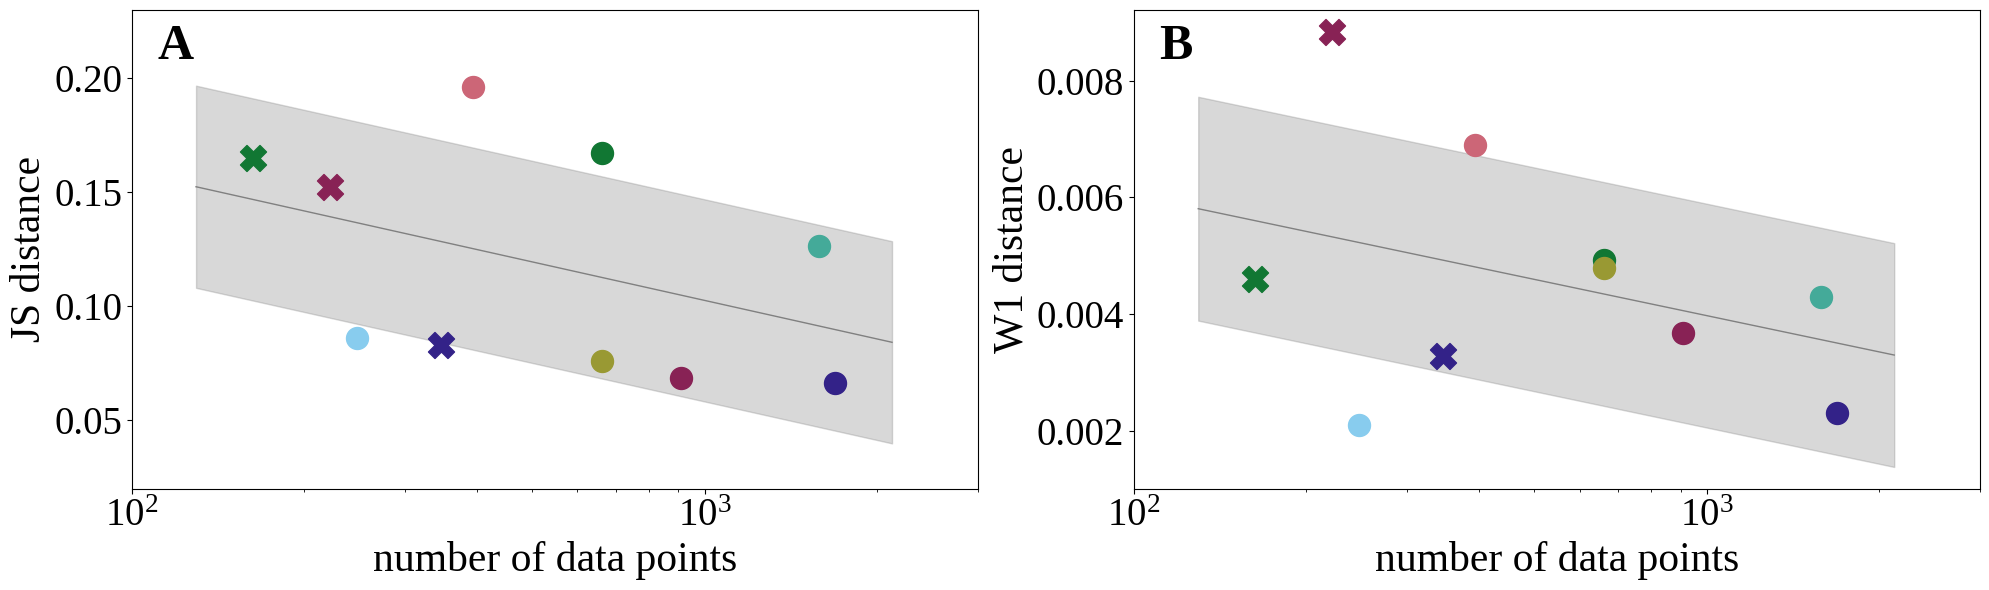

In [ ]:
list_of_models = create_model_file_list(126)
fig, axes = plt.subplots(1, 2, figsize=(FIG_WIDTH, FIG_HEIGHT))

ax = axes[0]
y_label = 'JS distance'
plot_trend_with_spatial_resolution(ax, 'js', y_label, 'A', True)
ax.set_xlim(100, 3000)
ax.set_ylim(0.02, 0.23)

ax = axes[1]
y_label = 'W1 distance'
plot_trend_with_spatial_resolution(ax, 'w1', y_label, 'B', True)
ax.set_xlim(100, 3000)

fig.tight_layout()
legend_name = f'trends_europeland_126m_2005-2015_with_regression'
fig.savefig(f'{legend_name}.pdf', bbox_inches="tight")

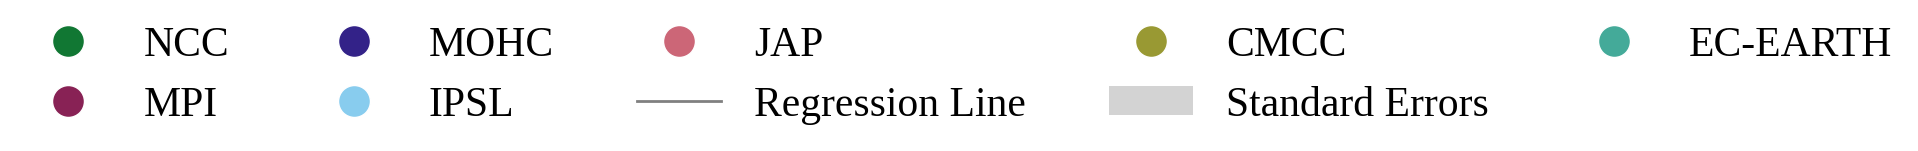

In [ ]:
fig_legend, ax_legend = plt.subplots(figsize=(FIG_WIDTH, FIG_HEIGHT / 4))
ax_legend.axis('off')
marker_size = 23

LABELS = {
    'NCC':  Line2D([], [], color="white", marker='o', markersize=marker_size, markerfacecolor=COLORS['NCC-LR'], label='NCC'),
    'MPI':  Line2D([], [], color="white", marker='o', markersize=marker_size, markerfacecolor=COLORS['MPI-LR'],  label='MPI'),
    'MOHC':  Line2D([], [], color="white", marker='o', markersize=marker_size, markerfacecolor=COLORS['MOHC-LR'], label='MOHC'),
    'IPSL': Line2D([], [], color="white", marker='o', markersize=marker_size, markerfacecolor=COLORS['IPSL'], label='IPSL'),
    'JAP':  Line2D([], [], color="white", marker='o', markersize=marker_size, markerfacecolor=COLORS['JAP'], label='JAP'),
    'Regression Line': Line2D([0], [0], color='grey', lw=2, label='Regression Line'),
    'CMCC':  Line2D([], [], color="white", marker='o', markersize=marker_size, markerfacecolor=COLORS['CMCC'], label='CMCC'),
    'Standard Errors': Patch(facecolor='lightgrey', edgecolor='none', label='Standard Errors'),
    'EC-EARTH':  Line2D([], [], color="white", marker='o', markersize=marker_size, markerfacecolor=COLORS['EC-EARTH'], label='EC-EARTH'),

}

ax_legend.legend(handles=LABELS.values(), labels=LABELS.keys(), frameon=False,
                 fontsize=30, loc='center', ncol=5)

legend_name = f'legend_europeland_126m_2005-2015_with_regression_without_era5'
fig_legend.savefig(f'{legend_name}.pdf', bbox_inches="tight")

average maximum value: Intercept Slope St.Dev. R-squared  P-value
average maximum value & 23.807 & 3.119 & 1.338 & 37.626 & 0.0447 \\


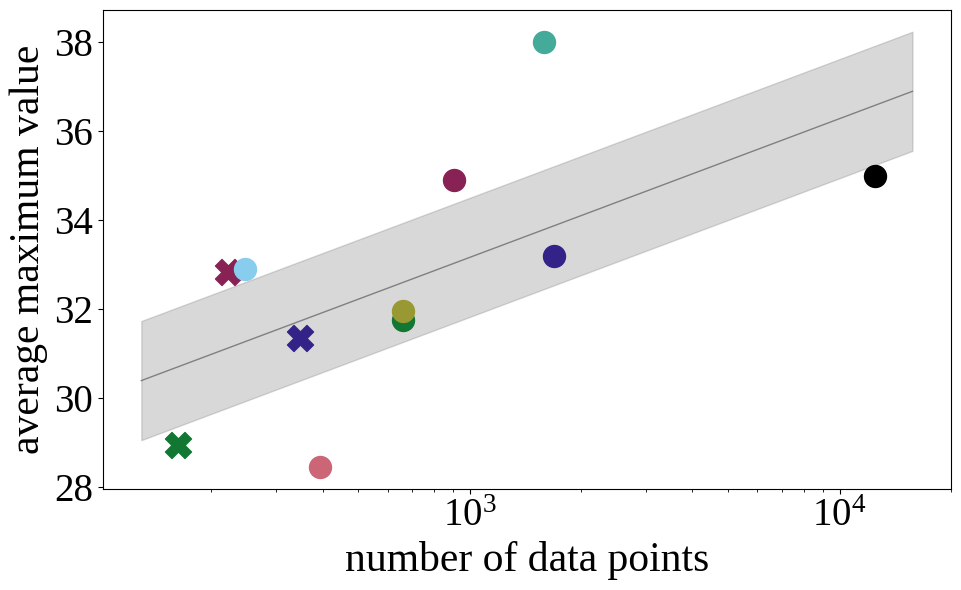

In [ ]:
list_of_models = create_model_file_list(126)
fig, ax = plt.subplots(1, 1, figsize=(int(FIG_WIDTH/2), FIG_HEIGHT))

y_label = 'average maximum value'
plot_trend_with_spatial_resolution(ax, 'max', y_label)

fig.tight_layout()
legend_name = f'extreme_values_europeland_126m_2005-2015_with_regression'
fig.savefig(f'{legend_name}.pdf', bbox_inches="tight")